In [2]:
from datasets import load_dataset, DatasetDict, Audio, load_from_disk
from transformers import pipeline
from evaluate import load
from tqdm import tqdm
from transformers.pipelines.pt_utils import KeyDataset
from transformers.models.whisper.english_normalizer import BasicTextNormalizer
from transformers import WhisperProcessor, Seq2SeqTrainer, Seq2SeqTrainingArguments
import torch
from dataclasses import dataclass
from typing import Any, Dict, List, Union
from transformers import WhisperForConditionalGeneration
from functools import partial
import torch._dynamo

torch._dynamo.config.suppress_errors = True


# Manual Preprocesing

In [21]:
common_voice = DatasetDict()

common_voice["train"] = load_dataset("mozilla-foundation/common_voice_11_0", "en", split="train")
common_voice["validation"] = load_dataset("mozilla-foundation/common_voice_11_0", "en", split="validation")
common_voice["test"] = load_dataset("mozilla-foundation/common_voice_11_0", "en", split="test")

common_voice = common_voice.select_columns(["audio", "sentence"])

/Users/fcisternas/miniconda3/envs/bats/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [7]:
processor = WhisperProcessor.from_pretrained(
    "openai/whisper-small"
)

In [16]:
sampling_rate = processor.feature_extractor.sampling_rate
common_voice = common_voice.cast_column("audio", Audio(sampling_rate=sampling_rate))

In [17]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor( #compute the mel spectogram
        audio=audio["array"],
        sampling_rate=audio["sampling_rate"],
        text=example["sentence"],
    )

    # compute input length of audio sample in seconds
    example["input_length"] = len(audio["array"]) / audio["sampling_rate"]

    return example

## Train

In [ ]:
common_voice['train'] = common_voice['train'].map(
    prepare_dataset,remove_columns=common_voice["train"].column_names, num_proc=4,
)

common_voice['train'].save_to_disk("datasets/common_voice/validation")

## Valid

In [19]:
common_voice['validation'] = common_voice['validation'].map(
    prepare_dataset, remove_columns=common_voice.column_names["validation"], num_proc=30
)

common_voice['validation'].save_to_disk('datasets/common_voice/validation')

Map (num_proc=30):   0%|          | 0/16354 [00:00<?, ? examples/s]

/Users/fcisternas/miniconda3/envs/bats/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


## Test

In [29]:
common_voice['test'] = common_voice['test'].map(
    prepare_dataset, remove_columns=common_voice.column_names["test"], num_proc=20
)

common_voice['test'].save_to_disk('datasets/common_voice/test')

Map (num_proc=20):   0%|          | 0/16354 [00:00<?, ? examples/s]

/Users/fcisternas/miniconda3/envs/bats/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Saving the dataset (0/32 shards):   0%|          | 0/16354 [00:00<?, ? examples/s]

# Fine Tuning

In [3]:
common_voice = DatasetDict()

#common_voice["train"] = load_from_disk('datasets/common_voice/train')
common_voice["validation"] = load_from_disk('datasets/common_voice/validation')
common_voice["test"] = load_from_disk('datasets/common_voice/test')

/Users/fcisternas/miniconda3/envs/bats/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [3]:
common_voice

DatasetDict({
    validation: Dataset({
        features: ['input_features', 'labels', 'input_length'],
        num_rows: 16354
    })
    test: Dataset({
        features: ['input_features', 'labels', 'input_length'],
        num_rows: 16354
    })
})

In [16]:
len(common_voice["validation"][3]['input_features'][0][0])

3000

In [4]:
max_input_length = 30.0

def is_audio_in_length_range(length):
    return length < max_input_length

In [5]:
common_voice = common_voice.filter(
    is_audio_in_length_range,
    input_columns=["input_length"],
)

In [6]:
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [
            {"input_features": feature["input_features"][0]} for feature in features
        ]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100
        )

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [7]:
processor = WhisperProcessor.from_pretrained(
    "openai/whisper-small"
)

In [8]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [9]:
metric = load("wer")

In [10]:
normalizer = BasicTextNormalizer()


def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    # compute orthographic wer
    wer_ortho = 100 * metric.compute(predictions=pred_str, references=label_str)

    # compute normalised WER
    pred_str_norm = [normalizer(pred) for pred in pred_str]
    label_str_norm = [normalizer(label) for label in label_str]
    # filtering step to only evaluate the samples that correspond to non-zero references:
    pred_str_norm = [
        pred_str_norm[i] for i in range(len(pred_str_norm)) if len(label_str_norm[i]) > 0
    ]
    label_str_norm = [
        label_str_norm[i]
        for i in range(len(label_str_norm))
        if len(label_str_norm[i]) > 0
    ]

    wer = 100 * metric.compute(predictions=pred_str_norm, references=label_str_norm)

    return {"wer_ortho": wer_ortho, "wer": wer}

In [11]:
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

In [12]:
# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(
    model.generate, language="en", task="transcribe", use_cache=True
)

In [17]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./bats",  # name of output directory
    resume_from_checkpoint=True,
    per_device_train_batch_size=1, #The batch size for training.
    gradient_accumulation_steps=16,  #Number of updates steps to accumulate the gradients for, before performing a backward/update pass, increase by 2x for every 2x decrease in batch size
    optim="adafactor", 
    torch_compile=True,
    learning_rate=1e-5,
    lr_scheduler_type="constant_with_warmup",
    warmup_steps=50,
    max_steps=200,  # increase to 4000 if you have your own GPU or a Colab paid plan
    logging_steps=25, #Number of update steps between two logs
    save_steps=10, #model checkpoint save frequency
    seed=42,
    gradient_checkpointing=True, #use gradient checkpointing to save memory at the expense of slower backward pass.
    evaluation_strategy="steps", #The evaluation strategy to adopt during training.
    per_device_eval_batch_size=1, #The batch size for evaluation.
    eval_steps=10,
    report_to=["tensorboard"], #The list of integrations to report the results and logs to.
    load_best_model_at_end=True,
    #metric_for_best_model="wer",
    #greater_is_better=False, #specify if better models should have a greater metric or not
    push_to_hub=False, #Whether or not to push the model to the Hub every time the model is saved
    prediction_loss_only=True, #When performing evaluation and generating predictions, only returns the loss
    eval_accumulation_steps = 1,
)

The speedups for torchdynamo mostly come wih GPU Ampere or higher and which is not detected here.


In [18]:
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=common_voice["validation"],
    eval_dataset=common_voice["test"],
    data_collator=data_collator,
    #compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [19]:
trainer.train()

  0%|          | 0/200 [00:00<?, ?it/s]

[2023-11-08 00:17:39,017] torch._dynamo.convert_frame: [WARNING] WON'T CONVERT forward /Users/fcisternas/miniconda3/envs/bats/lib/python3.10/site-packages/transformers/models/whisper/modeling_whisper.py line 1626 
[2023-11-08 00:17:39,017] torch._dynamo.convert_frame: [WARNING] due to: 
[2023-11-08 00:17:39,017] torch._dynamo.convert_frame: [WARNING] Traceback (most recent call last):
[2023-11-08 00:17:39,017] torch._dynamo.convert_frame: [WARNING]   File "/Users/fcisternas/miniconda3/envs/bats/lib/python3.10/site-packages/torch/_inductor/graph.py", line 906, in init_wrapper_code
[2023-11-08 00:17:39,017] torch._dynamo.convert_frame: [WARNING]     self.wrapper_code = wrapper_code_gen_cls()
[2023-11-08 00:17:39,017] torch._dynamo.convert_frame: [WARNING] torch._dynamo.exc.BackendCompilerFailed: backend='inductor' raised:
[2023-11-08 00:17:39,017] torch._dynamo.convert_frame: [WARNING] TypeError: 'NoneType' object is not callable
[2023-11-08 00:17:39,017] torch._dynamo.convert_frame: [WA

  0%|          | 0/16349 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
metrics = trainer.evaluate()

In [19]:
preds = trainer.predict(common_voice["test"][0])

KeyError: 0

# inference

In [2]:
cv_11_train = load_dataset("mozilla-foundation/common_voice_11_0", "en", split="train")
cv_11_test = load_dataset("mozilla-foundation/common_voice_11_0", "en", split="test")
cv_11_val = load_dataset("mozilla-foundation/common_voice_11_0", "en", split="validation")

/Users/fcisternas/miniconda3/envs/bats/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [4]:
device = "mps"

pipe = pipeline(
    "automatic-speech-recognition",
    model="openai/whisper-small",
    torch_dtype = torch.float16,
    device=device,
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
all_predictions = []

# run streamed inference
for prediction in tqdm(
    pipe(
        KeyDataset(cv_11_test, "audio"),
        max_new_tokens=128,
        generate_kwargs={"task": "transcribe"},
        batch_size=16,
    ),
    total=len(cv_11_test),
):
    all_predictions.append(prediction["text"])

  0%|          | 0/16354 [00:00<?, ?it/s]

100%|██████████| 16354/16354 [1:52:09<00:00,  2.43it/s] 


In [10]:
all_predictions

[' Joe Keaton disapproved of films and Buster also had reservations about the medium.',
 " She'd be alright.",
 ' Six.',
 ' All is well, that ends well.',
 ' It is a busy market town that serves a large surrounded area.',
 ' The team had Olympic champion Carolina Marin in the squad for the season.',
 ' Do you mean it?',
 ' The new patch is less invasive than the old one, but still causes regression.',
 ' How is Mozilla going to handle ambiguities like Q and Q?',
 ' وشهد بسيطة ونفاقتي',
 ' No one near the remote machine you could ring.',
 ' Sauce for the juice is sauce for the condor.',
 ' Grafs started writing songs when she was 4 years old.',
 ' Ezenkel Maik Shula was the former age coach at Alabama.',
 ' Kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa kwa k',
 ' The long-lived Bleach still s

In [6]:
wer_metric = load("wer")

wer_ortho = 100 * wer_metric.compute(
    references=cv_11_test["sentence"], predictions=all_predictions
)

In [7]:
wer_ortho

28.32954159148558

In [8]:
normalizer = BasicTextNormalizer()

# compute normalised WER
all_predictions_norm = [normalizer(pred) for pred in all_predictions]
all_references_norm = [normalizer(label) for label in cv_11_test["sentence"]]

# filtering step to only evaluate the samples that correspond to non-zero references
all_predictions_norm = [
    all_predictions_norm[i]
    for i in range(len(all_predictions_norm))
    if len(all_references_norm[i]) > 0
]
all_references_norm = [
    all_references_norm[i]
    for i in range(len(all_references_norm))
    if len(all_references_norm[i]) > 0
]

wer = 100 * wer_metric.compute(
    references=all_references_norm, predictions=all_predictions_norm
)

In [9]:
wer

24.299071426276384

# Plot Librosa

# Plot mel

In [4]:
import librosa.display
import librosa
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
common_voice = DatasetDict()

#common_voice["train"] = load_from_disk('datasets/common_voice/train')
common_voice["validation"] = load_from_disk('datasets/common_voice/validation')
common_voice["test"] = load_from_disk('datasets/common_voice/test')

In [5]:
common_voice

DatasetDict({
    validation: Dataset({
        features: ['input_features', 'labels', 'input_length'],
        num_rows: 16354
    })
    test: Dataset({
        features: ['input_features', 'labels', 'input_length'],
        num_rows: 16354
    })
})

In [6]:
common_voice['test']

Dataset({
    features: ['input_features', 'labels', 'input_length'],
    num_rows: 16354
})

In [7]:
common_voice['test'][0].keys()

dict_keys(['input_features', 'labels', 'input_length'])

In [23]:
len(common_voice['test'][0]['input_features'][0][0])

3000

In [27]:
common_voice['test'][0]['input_features'][0][2]

[-0.5807785987854004,
 -0.5807785987854004,
 -0.5807785987854004,
 -0.5222924947738647,
 0.08635473251342773,
 0.6673177480697632,
 0.8863943219184875,
 0.8805642127990723,
 0.6547929048538208,
 0.7204368710517883,
 0.7074151039123535,
 0.42469078302383423,
 0.49987363815307617,
 0.464245080947876,
 0.3647668957710266,
 0.23845767974853516,
 0.007554471492767334,
 0.1398937702178955,
 -0.025377631187438965,
 -0.26800692081451416,
 -0.07013976573944092,
 -0.10666489601135254,
 -0.08517742156982422,
 -0.2831401824951172,
 -0.1878962516784668,
 -0.14875972270965576,
 -0.1712254285812378,
 -0.10979175567626953,
 -0.11816775798797607,
 -0.10573136806488037,
 -0.06113409996032715,
 -0.22678935527801514,
 -0.3041595220565796,
 -0.4493492841720581,
 -0.14063429832458496,
 -0.19499874114990234,
 -0.273795485496521,
 -0.2772787809371948,
 -0.2899777889251709,
 -0.21123600006103516,
 -0.07665872573852539,
 -0.13445699214935303,
 -0.11209523677825928,
 -0.1652660369873047,
 -0.1197667121887207,
 -

In [38]:
input_features = common_voice['test'][3]['input_features'][0]

In [11]:
processor = WhisperProcessor.from_pretrained(
    "openai/whisper-small"
)

Text(0.5, 1.0, 'Whisper features')

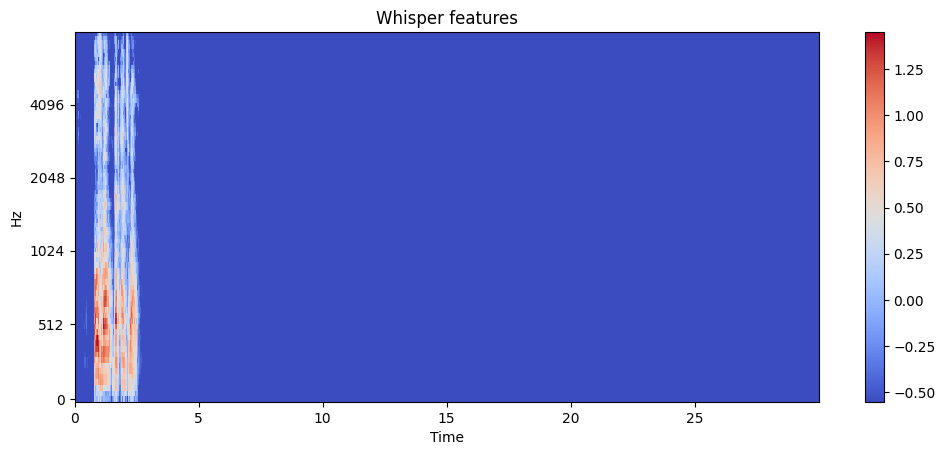

In [39]:
plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features),
    x_axis="time",
    y_axis="mel",
    sr=processor.feature_extractor.sampling_rate,
    hop_length=processor.feature_extractor.hop_length,
)
plt.colorbar()
plt.title("Whisper features")